In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:06<00:00, 620.81it/s]


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


In [8]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

ftr_list = ['usage', 'rate_incomplete_usage',
            'last_access', 
            'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'age_diff'
           ]
data_engine.select_features(ftr_list)

X = data_engine.data_
y = data_engine.target_

+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
+ Add feature: score.
+ Add feature: hardship.
Aggregate data over customer months.


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


In [11]:
from scipy.stats import boxcox
import seaborn as sns
import mglearn

ftr_list = ['usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'last_access', 
            'age', 'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'holiday',
            'age_diff'
           ]
ftr_list = ['usage', 'rate_incomplete_usage',
            'last_access', 
            'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'age_diff'
           ]
ftr_list_nontransform = []


X = []
Xt = []

for i, ftr in enumerate(ftr_list):
    x = data_engine.df_whizz_[ftr].values + 1
    
    if ftr == 'age_diff':
        x += 10
    xt,_ = boxcox(x)
    Xt.append(xt)
        
    X.append(x)
    
X = np.array(X).transpose()
Xt = np.array(Xt).transpose()
y = data_engine.df_whizz_.churn.values

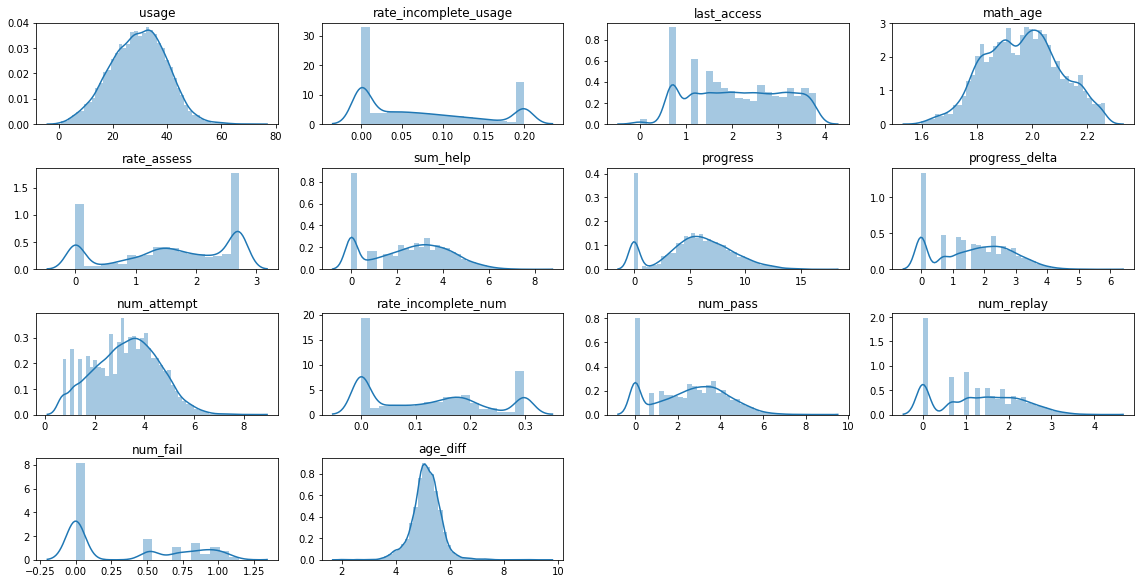

In [9]:
utility.plotlib.feature_distribution(data_engine.df_whizz_, ftr_list, 4, cfg, transform=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Xt)
Xt_scaled = scaler.transform(Xt)

## Gausian Mixture Model

In [17]:
from sklearn import mixture

n_components = 10
n_features = len(ftr_list)

gmm = mixture.GaussianMixture(
    n_components=n_components, 
    covariance_type='full',
    init_params='random',
    verbose=2, n_init=1, 
    tol=1e-6, max_iter=1000).fit(Xt_scaled)

group = gmm.predict(Xt_scaled)

Initialization 0
  Iteration 0	 time lapse 0.15959s	 ll change inf
  Iteration 10	 time lapse 0.81082s	 ll change 0.11818
  Iteration 20	 time lapse 0.72107s	 ll change 0.00630
  Iteration 30	 time lapse 0.71209s	 ll change 0.01980
  Iteration 40	 time lapse 0.74201s	 ll change 0.00973
  Iteration 50	 time lapse 0.78191s	 ll change 0.00573
  Iteration 60	 time lapse 0.74201s	 ll change 0.00433
  Iteration 70	 time lapse 0.72606s	 ll change 0.00060
  Iteration 80	 time lapse 0.72705s	 ll change 0.00047
  Iteration 90	 time lapse 0.73902s	 ll change 0.00011
  Iteration 100	 time lapse 0.74102s	 ll change 0.00002
  Iteration 110	 time lapse 0.71908s	 ll change 0.00003
  Iteration 120	 time lapse 0.73407s	 ll change 0.00403
  Iteration 130	 time lapse 0.74996s	 ll change 0.00030
  Iteration 140	 time lapse 0.72705s	 ll change 0.00006
  Iteration 150	 time lapse 0.73407s	 ll change 0.00002
  Iteration 160	 time lapse 0.71904s	 ll change 0.00001
  Iteration 170	 time lapse 0.72905s	 ll chang

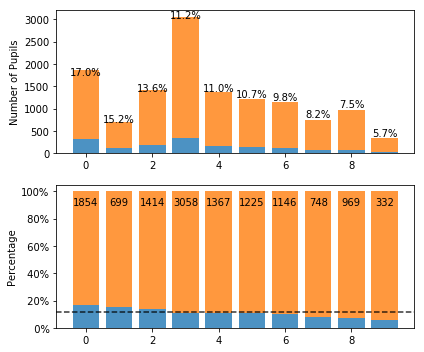

In [18]:
utility.plotlib.component_bar(y, group, n_components)

In [24]:
np.random.seed(0)
n_trials = 100
prediction_list = {}

for trial in range(0, n_trials):
    gmm = mixture.GaussianMixture(
        n_components=n_components, 
        covariance_type='full',
        init_params='random',
        verbose=2, n_init=1, 
        tol=1e-6, max_iter=1000).fit(Xt_scaled)

    prediction = gmm.predict(Xt_scaled)
    prediction_list[trial] = prediction

Initialization 0
  Iteration 0	 time lapse 0.12367s	 ll change inf
  Iteration 10	 time lapse 0.69714s	 ll change 0.11075


C:\Users\User\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  Iteration 20	 time lapse 0.79786s	 ll change 0.09545
  Iteration 30	 time lapse 0.84574s	 ll change 0.00406
  Iteration 40	 time lapse 0.72007s	 ll change 0.00390
  Iteration 50	 time lapse 0.72705s	 ll change 0.00638
  Iteration 60	 time lapse 0.73703s	 ll change 0.00063
  Iteration 70	 time lapse 0.82978s	 ll change 0.00003
  Iteration 80	 time lapse 0.73603s	 ll change -0.00002
  Iteration 90	 time lapse 0.73703s	 ll change -0.00001
  Iteration 100	 time lapse 0.73603s	 ll change -0.00000
  Iteration 110	 time lapse 0.74305s	 ll change -0.00000
Initialization converged: True	 time lapse 9.02784s	 ll 24.12286
Initialization 0
  Iteration 0	 time lapse 0.13265s	 ll change inf
  Iteration 10	 time lapse 0.69813s	 ll change 0.07666
  Iteration 20	 time lapse 0.69215s	 ll change 0.00883
  Iteration 30	 time lapse 0.71010s	 ll change 0.00157
  Iteration 40	 time lapse 0.72207s	 ll change 0.00517
  Iteration 50	 time lapse 0.92154s	 ll change 0.00798
  Iteration 60	 time lapse 0.82479s	 

  Iteration 80	 time lapse 0.91455s	 ll change 0.00022
  Iteration 90	 time lapse 0.79687s	 ll change 0.00015
  Iteration 100	 time lapse 0.76894s	 ll change 0.00003
  Iteration 110	 time lapse 0.74201s	 ll change 0.00001
  Iteration 120	 time lapse 0.75099s	 ll change 0.00001
  Iteration 130	 time lapse 0.74102s	 ll change 0.00001
  Iteration 140	 time lapse 0.74102s	 ll change 0.00003
  Iteration 150	 time lapse 0.75099s	 ll change 0.00016
  Iteration 160	 time lapse 0.75299s	 ll change 0.00019
  Iteration 170	 time lapse 0.75897s	 ll change 0.00006
  Iteration 180	 time lapse 0.74201s	 ll change 0.00002
  Iteration 190	 time lapse 0.75398s	 ll change 0.00001
  Iteration 200	 time lapse 0.80584s	 ll change 0.00000
  Iteration 210	 time lapse 0.75099s	 ll change 0.00000
Initialization converged: True	 time lapse 16.78309s	 ll 23.81737
Initialization 0
  Iteration 0	 time lapse 0.13564s	 ll change inf
  Iteration 10	 time lapse 0.90857s	 ll change 0.10138
  Iteration 20	 time lapse 0.8

  Iteration 20	 time lapse 0.75796s	 ll change 0.00983
  Iteration 30	 time lapse 0.75797s	 ll change 0.00172
  Iteration 40	 time lapse 0.76595s	 ll change 0.00043
  Iteration 50	 time lapse 0.75697s	 ll change 0.00088
  Iteration 60	 time lapse 0.76296s	 ll change 0.00030
  Iteration 70	 time lapse 0.97439s	 ll change 0.00016
  Iteration 80	 time lapse 0.86169s	 ll change 0.00011
  Iteration 90	 time lapse 0.75797s	 ll change 0.00010
  Iteration 100	 time lapse 0.77294s	 ll change 0.00013
  Iteration 110	 time lapse 0.78888s	 ll change 0.00038
  Iteration 120	 time lapse 0.77193s	 ll change 0.00061
  Iteration 130	 time lapse 0.80585s	 ll change 0.00016
  Iteration 140	 time lapse 0.77193s	 ll change 0.00019
  Iteration 150	 time lapse 0.78590s	 ll change 0.00014
  Iteration 160	 time lapse 0.78091s	 ll change 0.00006
  Iteration 170	 time lapse 0.75601s	 ll change 0.00002
  Iteration 180	 time lapse 0.78387s	 ll change 0.00000
  Iteration 190	 time lapse 0.78590s	 ll change 0.00000


  Iteration 40	 time lapse 0.74803s	 ll change 0.02530
  Iteration 50	 time lapse 0.76192s	 ll change 0.00018
  Iteration 60	 time lapse 0.74700s	 ll change 0.00002
  Iteration 70	 time lapse 0.76297s	 ll change 0.00000
Initialization converged: True	 time lapse 5.99196s	 ll 23.86000
Initialization 0
  Iteration 0	 time lapse 0.11669s	 ll change inf
  Iteration 10	 time lapse 0.71113s	 ll change 0.93692
  Iteration 20	 time lapse 0.76791s	 ll change 0.01294
  Iteration 30	 time lapse 0.76795s	 ll change 0.00062
  Iteration 40	 time lapse 0.76595s	 ll change 0.00025
  Iteration 50	 time lapse 0.77296s	 ll change 0.00031
  Iteration 60	 time lapse 0.76692s	 ll change 0.00075
  Iteration 70	 time lapse 0.75299s	 ll change 0.00006
  Iteration 80	 time lapse 0.75997s	 ll change 0.00002
  Iteration 90	 time lapse 0.76695s	 ll change 0.00000
Initialization converged: True	 time lapse 7.03618s	 ll 24.04533
Initialization 0
  Iteration 0	 time lapse 0.11568s	 ll change inf
  Iteration 10	 time 

  Iteration 160	 time lapse 0.76296s	 ll change 0.00024
  Iteration 170	 time lapse 0.79786s	 ll change 0.00003
  Iteration 180	 time lapse 0.81980s	 ll change 0.00000
  Iteration 190	 time lapse 0.79886s	 ll change 0.00000
Initialization converged: True	 time lapse 15.31701s	 ll 23.74984
Initialization 0
  Iteration 0	 time lapse 0.13663s	 ll change inf
  Iteration 10	 time lapse 0.73603s	 ll change 0.24712
  Iteration 20	 time lapse 0.77296s	 ll change 0.00923
  Iteration 30	 time lapse 0.77490s	 ll change 0.01448
  Iteration 40	 time lapse 0.76695s	 ll change 0.03101
  Iteration 50	 time lapse 0.87167s	 ll change 0.00092
  Iteration 60	 time lapse 0.96242s	 ll change 0.00006
  Iteration 70	 time lapse 0.77792s	 ll change 0.00001
  Iteration 80	 time lapse 0.78091s	 ll change 0.00000
Initialization converged: True	 time lapse 6.67414s	 ll 24.29328
Initialization 0
  Iteration 0	 time lapse 0.12376s	 ll change inf
  Iteration 10	 time lapse 0.71808s	 ll change 0.08166
  Iteration 20	 

  Iteration 60	 time lapse 0.90558s	 ll change 0.00169
  Iteration 70	 time lapse 0.90159s	 ll change 0.01362
  Iteration 80	 time lapse 0.76396s	 ll change 0.00074
  Iteration 90	 time lapse 0.76894s	 ll change 0.00089
  Iteration 100	 time lapse 0.77094s	 ll change 0.00061
  Iteration 110	 time lapse 0.76994s	 ll change 0.00013
  Iteration 120	 time lapse 0.74800s	 ll change 0.00004
  Iteration 130	 time lapse 0.74999s	 ll change 0.00016
  Iteration 140	 time lapse 0.77293s	 ll change 0.00133
  Iteration 150	 time lapse 0.76297s	 ll change 0.00007
  Iteration 160	 time lapse 0.77392s	 ll change -0.00014
  Iteration 170	 time lapse 0.76795s	 ll change 0.00001
  Iteration 180	 time lapse 0.76794s	 ll change 0.00009
  Iteration 190	 time lapse 0.75598s	 ll change 0.00002
  Iteration 200	 time lapse 0.75996s	 ll change 0.00000
  Iteration 210	 time lapse 0.76595s	 ll change 0.00000
  Iteration 220	 time lapse 0.75299s	 ll change 0.00000
  Iteration 230	 time lapse 0.75098s	 ll change 0.0

  Iteration 120	 time lapse 0.75498s	 ll change 0.00001
  Iteration 130	 time lapse 0.75199s	 ll change 0.00000
  Iteration 140	 time lapse 0.74999s	 ll change 0.00000
Initialization converged: True	 time lapse 11.13321s	 ll 23.98883
Initialization 0
  Iteration 0	 time lapse 0.12167s	 ll change inf
  Iteration 10	 time lapse 0.70811s	 ll change 0.11068
  Iteration 20	 time lapse 0.74800s	 ll change 0.02348
  Iteration 30	 time lapse 0.75398s	 ll change 0.02128
  Iteration 40	 time lapse 0.73902s	 ll change 0.00103
  Iteration 50	 time lapse 0.74800s	 ll change 0.00030
  Iteration 60	 time lapse 0.75398s	 ll change 0.00187
  Iteration 70	 time lapse 0.75199s	 ll change 0.00198
  Iteration 80	 time lapse 0.74401s	 ll change 0.00019
  Iteration 90	 time lapse 0.74401s	 ll change 0.00006
  Iteration 100	 time lapse 0.76795s	 ll change 0.00003
  Iteration 110	 time lapse 0.94248s	 ll change 0.00106
  Iteration 120	 time lapse 0.84175s	 ll change 0.00008
  Iteration 130	 time lapse 0.76694s

  Iteration 20	 time lapse 0.72606s	 ll change 0.02588
  Iteration 30	 time lapse 0.75600s	 ll change 0.00162
  Iteration 40	 time lapse 0.78686s	 ll change 0.03183
  Iteration 50	 time lapse 0.75798s	 ll change 0.00134
  Iteration 60	 time lapse 0.76295s	 ll change 0.00831
  Iteration 70	 time lapse 0.78989s	 ll change 0.00012
  Iteration 80	 time lapse 0.76096s	 ll change 0.00198
  Iteration 90	 time lapse 0.85172s	 ll change 0.00004
  Iteration 100	 time lapse 0.96342s	 ll change 0.00001
  Iteration 110	 time lapse 0.78095s	 ll change 0.00000
  Iteration 120	 time lapse 0.76591s	 ll change 0.00000
Initialization converged: True	 time lapse 10.19671s	 ll 24.13605
Initialization 0
  Iteration 0	 time lapse 0.11370s	 ll change inf
  Iteration 10	 time lapse 0.72306s	 ll change 0.13417
  Iteration 20	 time lapse 0.75398s	 ll change 0.00362
  Iteration 30	 time lapse 0.75299s	 ll change 0.01141
  Iteration 40	 time lapse 0.74999s	 ll change 0.00192
  Iteration 50	 time lapse 0.74800s	 ll

  Iteration 90	 time lapse 0.74900s	 ll change 0.00003
  Iteration 100	 time lapse 0.75498s	 ll change 0.00001
  Iteration 110	 time lapse 0.74401s	 ll change 0.00001
  Iteration 120	 time lapse 0.82380s	 ll change 0.00001
  Iteration 130	 time lapse 0.97040s	 ll change 0.00003
  Iteration 140	 time lapse 0.77592s	 ll change 0.00003
  Iteration 150	 time lapse 0.75598s	 ll change 0.00001
  Iteration 160	 time lapse 0.75697s	 ll change 0.00001
  Iteration 170	 time lapse 0.73902s	 ll change 0.00000
  Iteration 180	 time lapse 0.73902s	 ll change 0.00000
Initialization converged: True	 time lapse 14.00949s	 ll 24.04115
Initialization 0
  Iteration 0	 time lapse 0.11270s	 ll change inf
  Iteration 10	 time lapse 0.70112s	 ll change 0.13340
  Iteration 20	 time lapse 0.73204s	 ll change 0.04717
  Iteration 30	 time lapse 0.74201s	 ll change 0.00434
  Iteration 40	 time lapse 0.75801s	 ll change 0.00184
  Iteration 50	 time lapse 0.75494s	 ll change 0.00031
  Iteration 60	 time lapse 0.7629

  Iteration 100	 time lapse 0.76599s	 ll change 0.00002
  Iteration 110	 time lapse 0.74497s	 ll change 0.00000
  Iteration 120	 time lapse 0.76994s	 ll change 0.00000
Initialization converged: True	 time lapse 9.75589s	 ll 23.47261
Initialization 0
  Iteration 0	 time lapse 0.11269s	 ll change inf
  Iteration 10	 time lapse 0.70212s	 ll change 0.12345
  Iteration 20	 time lapse 0.74201s	 ll change 0.04612
  Iteration 30	 time lapse 0.74999s	 ll change 0.00215
  Iteration 40	 time lapse 0.75997s	 ll change 0.00276
  Iteration 50	 time lapse 0.76296s	 ll change 0.07664
  Iteration 60	 time lapse 0.73204s	 ll change 0.00065
  Iteration 70	 time lapse 0.74900s	 ll change 0.00018
  Iteration 80	 time lapse 0.73906s	 ll change 0.00021
  Iteration 90	 time lapse 0.75295s	 ll change 0.00010
  Iteration 100	 time lapse 0.75098s	 ll change 0.00000
Initialization converged: True	 time lapse 7.55578s	 ll 23.82181
Initialization 0
  Iteration 0	 time lapse 0.11368s	 ll change inf
  Iteration 10	 t

In [32]:
i = 1

expectations = y
base = expectations.sum()/expectations.shape[0]

predictions = prediction_list[i]


In [97]:
def compute_predictionScore(expectations, prediction_list, n_components, criterion='deviation'):

    map_score = {}

    for trial, predictions in prediction_list.items():
        num_pupil = []
        num_churn = []

        for i in range(0, n_components):
            idx_pupils = np.where(predictions==i)[0]
            if idx_pupils.size > 0: # remove empty groups
                num_pupil.append(idx_pupils.shape[0])
                num_churn.append(expectations[idx_pupils].sum())
        
        df = pd.DataFrame({'num_pupil':num_pupil, 'num_churn':num_churn})
        df = df.assign(rate_churn=df.num_churn/df.num_pupil)

        if criterion == 'deviation':
            score = (abs(df.rate_churn-base) * df.num_pupil).sum()
        elif criterion == 'variance':
            score = (((df.rate_churn-base) * df.num_pupil)**2).sum()
        elif criterion == 'max_rate':
            score = max(df.rate_churn-base)
        elif criterion == 'max_number':
            score = max((df.rate_churn-base)*df.num_pupil)
        elif criterion == 'min_rate':
            score = -min(df.rate_churn-base)
        elif criterion == 'min_number':
            score = -min((df.rate_churn-base)*df.num_pupil)
        else:
            raise IndexError(f'The input criterion \'{criterion}\' has not been defined yet!')
        
        map_score[trial] = score
    
    return map_score


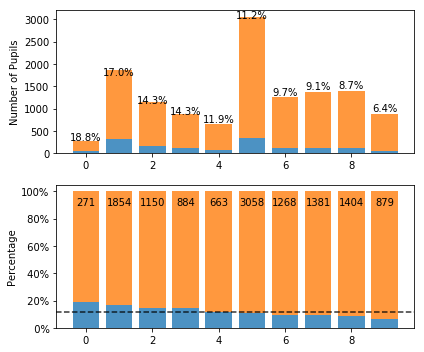

C:\Users\User\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [99]:
map_score = compute_predictionScore(y, prediction_list, n_components, 'deviation')

trial_ls = max(map_score, key=map_score.get)

utility.plotlib.component_bar(y, prediction_list[trial_ls], n_components)

In [8]:
n_components = 20
bic = []

for k in range(1, n_components+1):
    gmm = mixture.GaussianMixture(
        n_components=k, covariance_type='full', verbose=0, n_init=1, tol=1e-6, max_iter=1000).fit(Xt_scaled)
    bic.append(gmm.bic(Xt_scaled))
    print('Number of components = {}'.format(k))

Number of components = 1
Number of components = 2
Number of components = 3
Number of components = 4
Number of components = 5
Number of components = 6
Number of components = 7
Number of components = 8
Number of components = 9
Number of components = 10
Number of components = 11
Number of components = 12
Number of components = 13
Number of components = 14
Number of components = 15
Number of components = 16
Number of components = 17
Number of components = 18
Number of components = 19
Number of components = 20


Text(0.5,0,'Number of Components')

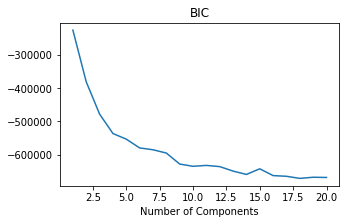

In [14]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.plot(range(1, n_components+1), bic)
ax.set_title('BIC')
ax.set_xlabel('Number of Components')

## Bayesian Gaussian Mixture Model

In [61]:
n_components = 10
dpgmm = mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-5, max_iter=10000, n_init=1, verbose=2).fit(Xt_scaled)

Initialization 0
  Iteration 0	 time lapse 0.13563s	 ll change inf
  Iteration 10	 time lapse 0.70910s	 ll change 854.73627
  Iteration 20	 time lapse 0.80485s	 ll change 11.17732
  Iteration 30	 time lapse 0.77393s	 ll change 1.86389
  Iteration 40	 time lapse 0.76595s	 ll change 0.50264
  Iteration 50	 time lapse 0.76100s	 ll change 0.19735
  Iteration 60	 time lapse 0.77090s	 ll change 0.08710
  Iteration 70	 time lapse 0.75701s	 ll change 0.03393
  Iteration 80	 time lapse 0.76092s	 ll change 0.01241
  Iteration 90	 time lapse 0.76396s	 ll change 0.00446
  Iteration 100	 time lapse 0.77892s	 ll change 0.00160
  Iteration 110	 time lapse 0.75996s	 ll change 0.00057
  Iteration 120	 time lapse 0.75997s	 ll change 0.00021
  Iteration 130	 time lapse 0.77792s	 ll change 0.00007
  Iteration 140	 time lapse 0.77592s	 ll change 0.00003
  Iteration 150	 time lapse 0.90059s	 ll change 0.00001
Initialization converged: True	 time lapse 11.85727s	 ll 340165.10094


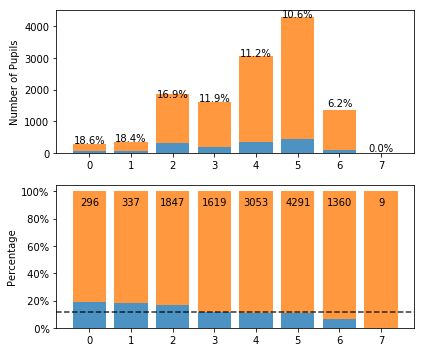

In [99]:
group = dpgmm.predict(Xt_scaled)

component_bar(y, group, n_components)

In [104]:
np.random.seed(0)
n_trials = 100
n_components = 10
prediction_list_dpgmm = {}

for trial in range(0, n_trials):
    print('Trial NO. = {}'.format(trial))
    dpgmm = mixture.BayesianGaussianMixture(
        n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
        weight_concentration_prior_type='dirichlet_process',
        mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
        init_params="random", tol=1e-4, max_iter=1000, n_init=1, 
        verbose=2, verbose_interval=100).fit(Xt_scaled)

    prediction = dpgmm.predict(Xt_scaled)
    prediction_list_dpgmm[trial] = prediction

Trial NO. = 0
Initialization 0
  Iteration 0	 time lapse 0.13863s	 ll change inf
Initialization converged: True	 time lapse 4.78220s	 ll 340419.73230
Trial NO. = 1
Initialization 0
  Iteration 0	 time lapse 0.13763s	 ll change inf


C:\Users\User\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  Iteration 100	 time lapse 13.54592s	 ll change 3.68281
Initialization converged: True	 time lapse 19.84602s	 ll 342067.18230
Trial NO. = 2
Initialization 0
  Iteration 0	 time lapse 0.12366s	 ll change inf
  Iteration 100	 time lapse 10.73228s	 ll change 0.10667
Initialization converged: True	 time lapse 15.02379s	 ll 342025.45161
Trial NO. = 3
Initialization 0
  Iteration 0	 time lapse 0.12366s	 ll change inf
  Iteration 100	 time lapse 13.19968s	 ll change 1.29462
Initialization converged: True	 time lapse 18.17436s	 ll 342225.49702
Trial NO. = 4
Initialization 0
  Iteration 0	 time lapse 0.14162s	 ll change inf
Initialization converged: True	 time lapse 10.31838s	 ll 340411.36019
Trial NO. = 5
Initialization 0
  Iteration 0	 time lapse 0.12466s	 ll change inf
Initialization converged: True	 time lapse 10.14185s	 ll 340545.15854
Trial NO. = 6
Initialization 0
  Iteration 0	 time lapse 0.11269s	 ll change inf
Initialization converged: True	 time lapse 13.71429s	 ll 342225.87062
Tria

  Iteration 100	 time lapse 11.62389s	 ll change 89.40638
Initialization converged: True	 time lapse 19.10587s	 ll 342024.40536
Trial NO. = 38
Initialization 0
  Iteration 0	 time lapse 0.11668s	 ll change inf
  Iteration 100	 time lapse 13.55177s	 ll change 0.00472
  Iteration 200	 time lapse 14.21492s	 ll change 2.89184
Initialization converged: True	 time lapse 33.49838s	 ll 342222.74958
Trial NO. = 39
Initialization 0
  Iteration 0	 time lapse 0.12067s	 ll change inf
  Iteration 100	 time lapse 13.21563s	 ll change 6.16203
Initialization converged: True	 time lapse 18.03473s	 ll 343096.67872
Trial NO. = 40
Initialization 0
  Iteration 0	 time lapse 0.14660s	 ll change inf
  Iteration 100	 time lapse 11.66184s	 ll change 0.11484
Initialization converged: True	 time lapse 22.13077s	 ll 340660.12619
Trial NO. = 41
Initialization 0
  Iteration 0	 time lapse 0.11968s	 ll change inf
  Iteration 100	 time lapse 11.45036s	 ll change 0.69503
Initialization converged: True	 time lapse 20.573

  Iteration 100	 time lapse 11.60793s	 ll change 3.86251
Initialization converged: True	 time lapse 22.49180s	 ll 340649.00046
Trial NO. = 75
Initialization 0
  Iteration 0	 time lapse 0.12167s	 ll change inf
  Iteration 100	 time lapse 13.61157s	 ll change 4.44333
Initialization converged: True	 time lapse 18.60221s	 ll 340404.53802
Trial NO. = 76
Initialization 0
  Iteration 0	 time lapse 0.11868s	 ll change inf
Initialization converged: True	 time lapse 11.59896s	 ll 340548.46111
Trial NO. = 77
Initialization 0
  Iteration 0	 time lapse 0.11867s	 ll change inf
  Iteration 100	 time lapse 11.57901s	 ll change 4.51477
  Iteration 200	 time lapse 12.06172s	 ll change 0.00284
Initialization converged: True	 time lapse 35.92285s	 ll 341108.47397
Trial NO. = 78
Initialization 0
  Iteration 0	 time lapse 0.12068s	 ll change inf
  Iteration 100	 time lapse 13.58664s	 ll change 0.00778
  Iteration 200	 time lapse 14.49521s	 ll change 0.65653
  Iteration 300	 time lapse 14.32366s	 ll change 0

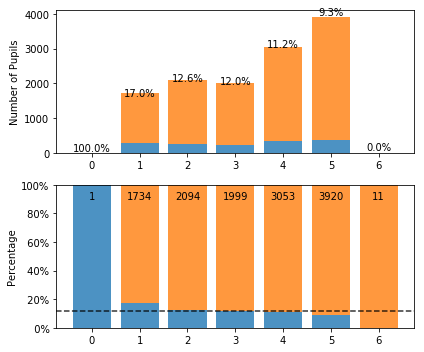

C:\Users\User\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [113]:
map_score_dpgmm = compute_predictionScore(y, prediction_list_dpgmm, n_components, 'max_rate')
trial_ls = max(map_score_dpgmm, key=map_score_dpgmm.get)
utility.plotlib.component_bar(y, prediction_list_dpgmm[trial_ls], n_components)